todo
9. explain (comment on) that you've got 2 models in the questionnair

# Hate speech Detection

In [427]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix, f1_score

from keras.callbacks import EarlyStopping
from keras.layers import LSTM, Dense, Embedding
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

### Data Exploration

In [428]:
data = pd.read_csv('Hate Speech Data.csv')
data

,case_id,test_case,label_gold,target_ident
0,1,I hate women.,hateful,women
1,2,I hate trans people.,hateful,trans people
2,3,I hate gay people.,hateful,gay people
3,4,I hate black people.,hateful,black people
4,5,I hate disabled people.,hateful,disabled people
...,...,...,...,...
3896,3897,Gay people are all complete 4ssholes.,hateful,gay people
3897,3898,Black people are all complete 4ssholes.,hateful,black people
3898,3899,Disabled people are all complete 4ssholes.,hateful,disabled people
3899,3900,Muslims are all complete 4ssholes.,hateful,Muslims


Looks like the dataset contains some missing values in the target_ident column, which we'll have to deal with later

In [429]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3901 entries, 0 to 3900
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   case_id       3901 non-null   int64 
 1   test_case     3901 non-null   object
 2   label_gold    3901 non-null   object
 3   target_ident  3606 non-null   object
dtypes: int64(1), object(3)
memory usage: 122.0+ KB


In [430]:
data[data.isna().any(axis=1)].head()

,case_id,test_case,label_gold,target_ident
1271,1272,"Fucking hell, what a day.",non-hateful,NaN
1272,1273,That's a great fucking idea.,non-hateful,NaN
1273,1274,No fucking way.,non-hateful,NaN
1274,1275,I'm so fucking excited.,non-hateful,NaN
1275,1276,Are you fucking kidding me?,non-hateful,NaN


No duplicate texts found

In [431]:
print(f'''duplicate texts: {data['test_case'].duplicated().any()}''')

duplicate texts: False


While the target groups are essentially balanced, the same cannot be said for the hate/non-hate categories

In [432]:
# Using display() to display both at the same time without weird notebook formatting.
# (Won't comment on any future use of display() again. Same as for any other obvious piece of code)
display(
    pd.DataFrame(data['label_gold'].value_counts()),
    pd.DataFrame(data['target_ident'].value_counts())
)

,count
label_gold,
hateful,2659
non-hateful,1242


,count
target_ident,
gay people,577
women,535
disabled people,510
Muslims,510
black people,504
trans people,485
immigrants,485


No unusually short/long texts

In [433]:
longest_text_length = data['test_case'].str.len().max()
shortest_text_length = data['test_case'].str.len().min()

longest_text_index = data['test_case'].str.len().idxmax()
shortest_text_index = data['test_case'].str.len().idxmin()

print(
    f'''Shortest: {longest_text_length} chars, "{data['test_case'][longest_text_index]}"\n'''
    f'''Longest: {shortest_text_length} chars, "{data['test_case'][shortest_text_index]}"'''
)

Shortest: 104 chars, "When will it finally be clear to people that it's in a disabled person's nature to be an annoying prick?"
Longest: 11 chars, "Ihate women"


### Data cleaning

Drop irrelevant columns and rename the rest to something more appropriate

In [434]:
data = data.drop('case_id', axis=1)
data = data.rename(columns=
{
    'test_case': 'text',
    'label_gold': 'label',
    'target_ident': 'target',
})

data.head()

,text,label,target
0,I hate women.,hateful,women
1,I hate trans people.,hateful,trans people
2,I hate gay people.,hateful,gay people
3,I hate black people.,hateful,black people
4,I hate disabled people.,hateful,disabled people


It appears as though non of the missing targets have any relevant hate speech associated with them. This can easily be varified by manually looking at the dataset (given its tiny size), But alas, given my horrendous dyslexia i decided to programmatically varify it as a sanity check

In [435]:
# Easier than grabbing them from the "target" column and removing the trailing "people"
target_search_words = [
    'gay',
    'women',
    'disabled',
    'Muslims',
    'black',
    'trans',
    'immigrants'
]

target_nans = data[data['target'].isna()]

'''
After having spent 9 hours (no kidding) trying to make this piece of *** work with pandas queries,
i settled for the caveman solution of two loops. Being bad at programming is frankly an understatement at this point.
Might as well dig my own grave. And even that'd be done using for loops...
'''
for _, row in target_nans.iterrows():
    for target_search_word in target_search_words:
        # Split by words and search each one
        if target_search_word in row['text'].split(' '):
            print(f'''found target word in: "{row['text']}" row''')

I'm now confident in dropping all rows with target NaN values

In [436]:
data = data.dropna()

Balancing the dataset

In [437]:
# Get the number of hate/non-hate rows
hateful_count = data['label'].value_counts()['hateful']
non_hateful_count = data['label'].value_counts()['non-hateful']

hateful_to_drop_count = hateful_count - non_hateful_count

# Randomly sample the rows and drop
rows_indexes_to_remove = data[data['label'] == 'hateful'].sample(n=hateful_to_drop_count).index
data = data.drop(rows_indexes_to_remove)

display(
    pd.DataFrame(data['label'].value_counts()),
    pd.DataFrame(data['target'].value_counts())
)

,count
label,
hateful,947
non-hateful,947


,count
target,
gay people,313
disabled people,287
women,286
Muslims,270
black people,258
trans people,241
immigrants,239


### Data Preprocessing

Shuffle the dataset

In [438]:
data = data.sample(frac=1)

# Reset index after having both balanced and shuffled
data = data.reset_index(drop=True)
data.head()

,text,label,target
0,The world would be worse off without Muslims l...,non-hateful,Muslims
1,I don't like people in general but I have no p...,non-hateful,gay people
2,You must be seriously sad to write things like...,non-hateful,gay people
3,I absolutely loathe black people.,hateful,black people
4,You disabled people are all dishonest.,hateful,disabled people


Tokenize and pad the texts

In [439]:
max_words_to_use = 1000

# Use 1k words as that's plenty for our use case
tokenizer = Tokenizer(num_words=max_words_to_use)
tokenizer.fit_on_texts(data['text'])
tokenized_texts = tokenizer.texts_to_sequences(data['text'])

# printing using loop for easier viewing
for i in range(5):
    print(f'Sequence {i}: {tokenized_texts[i]}')

Sequence 0: [10, 121, 34, 9, 169, 131, 143, 22, 7, 4]
Sequence 1: [6, 84, 7, 1, 13, 308, 36, 6, 29, 46, 309, 148, 20, 16, 1]
Sequence 2: [4, 71, 9, 103, 279, 3, 104, 105, 7, 16, 1, 68, 3, 98]
Sequence 3: [6, 77, 445, 14, 1]
Sequence 4: [4, 12, 1, 2, 8, 423]


Given the stochasticity of "sample()" when balancing our dataset, we now need to figure out the longest sequence of tokenized words before we can perform padding.
###### _Well... we don't technically need to know this... but i'd certainly never forgive myself knowing i had left unnecessary zeros in the padding process._

In [440]:
max_sequence_length = len(max(tokenized_texts, key=len))
print(f'longest sequence: {max_sequence_length}')

longest sequence: 20


In [441]:
# Double the max padding length to allow for longer sentences to be classified once we use actually wanna use the model.
# (The resource hit is negligable)
max_sequence_length = max_sequence_length * 2

# Pad the sequences to make them of uniform length
tokenized_padded_texts = pad_sequences(tokenized_texts, maxlen=max_sequence_length)

for i in range(5):
    print(f'seq {i}: {tokenized_padded_texts[i].tolist()}')

seq 0: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 121, 34, 9, 169, 131, 143, 22, 7, 4]
seq 1: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 84, 7, 1, 13, 308, 36, 6, 29, 46, 309, 148, 20, 16, 1]
seq 2: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 71, 9, 103, 279, 3, 104, 105, 7, 16, 1, 68, 3, 98]
seq 3: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 77, 445, 14, 1]
seq 4: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 12, 1, 2, 8, 423]


One-hot encode the labels

In [442]:
label_binarizer = LabelBinarizer()
onehot_encoded_labels = label_binarizer.fit_transform(data['label'])
onehot_encoded_targets = label_binarizer.fit_transform(data['target'])

print(f'labels: {onehot_encoded_labels.tolist()[:5]}')

for i in range(5):
    print(f'Target {i}: {onehot_encoded_targets[i].tolist()}')

labels: [[1], [1], [1], [0], [0]]
Target 0: [1, 0, 0, 0, 0, 0, 0]
Target 1: [0, 0, 0, 1, 0, 0, 0]
Target 2: [0, 0, 0, 1, 0, 0, 0]
Target 3: [0, 1, 0, 0, 0, 0, 0]
Target 4: [0, 0, 1, 0, 0, 0, 0]


Train/test split

In [443]:
train_texts, test_texts, train_labels, test_labels, train_targets, test_targets = train_test_split(
    tokenized_padded_texts,
    onehot_encoded_labels,
    onehot_encoded_targets,
    test_size=0.2
)

print(
    f'train_texts shape: {np.shape(train_texts)}\n'
    f'train_labels shape: {np.shape(train_labels)}\n'
    f'train_targets shape: {np.shape(train_targets)}\n'
    f'test_texts shape: {np.shape(test_texts)}\n'
    f'test_labels shape: {np.shape(test_labels)}\n'
    f'test_targets shape: {np.shape(test_targets)}'
)

train_texts shape: (1515, 40)
train_labels shape: (1515, 1)
train_targets shape: (1515, 7)
test_texts shape: (379, 40)
test_labels shape: (379, 1)
test_targets shape: (379, 7)


# Model building, training and testing
###### At last!

In [444]:
# All models and histories will be stored here
models = {}

# Easiest and most human readable way of doing it while training two models with different parameters
# without having to use a bunch of ugly if-statements and duplicate code. Trust me, i tried the other methods.
model_parameters = zip(
    ['Hate Detection', 'Target Detection'],
    [train_labels, train_targets],
    ['sigmoid', 'softmax'],
    ['binary_crossentropy', 'categorical_crossentropy']
)

for model_name, labels, output_activation_function, loss_function in model_parameters:
    model = Sequential([
        Embedding(
            input_dim=max_words_to_use,
            input_length=max_sequence_length,
            output_dim=32
        ),
        LSTM(units=32, activation='tanh'),
        
        # The number of neurons at the output depends on the number of classes.
        # We get the number of classes by taking the shape of the label arrays as they're one-hot encoded
        Dense(labels.shape[1], activation=output_activation_function)
    ])

    model.compile(optimizer='adam', loss=loss_function, metrics=['accuracy'])

    # Using a patience and start_from_epoch of 10 as the model is still all over the place before that
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, start_from_epoch=10)
    history = model.fit(train_texts, labels, epochs=100, validation_split=0.2, callbacks=[early_stopping], verbose=1)
    models[model_name] = {'model': model, 'history': history}

Epoch 1/100


38/38 [==============================] - 7s 45ms/step - loss: 0.6847 - accuracy: 0.5520 - val_loss: 0.6684 - val_accuracy: 0.7657
Epoch 2/100
38/38 [==============================] - 1s 31ms/step - loss: 0.6027 - accuracy: 0.7599 - val_loss: 0.5074 - val_accuracy: 0.7789
Epoch 3/100
38/38 [==============================] - 1s 28ms/step - loss: 0.3902 - accuracy: 0.8416 - val_loss: 0.3918 - val_accuracy: 0.8152
Epoch 4/100
38/38 [==============================] - 1s 33ms/step - loss: 0.2312 - accuracy: 0.9208 - val_loss: 0.2471 - val_accuracy: 0.8977
Epoch 5/100
38/38 [==============================] - 1s 27ms/step - loss: 0.1369 - accuracy: 0.9563 - val_loss: 0.1898 - val_accuracy: 0.9505
Epoch 6/100
38/38 [==============================] - 1s 36ms/step - loss: 0.0747 - accuracy: 0.9818 - val_loss: 0.1584 - val_accuracy: 0.9571
Epoch 7/100
38/38 [==============================] - 1s 34ms/step - loss: 0.0431 - accuracy: 0.9934 - val_loss: 0.1164 - val_accuracy: 0.9538
Epoch 8/100
38/38 

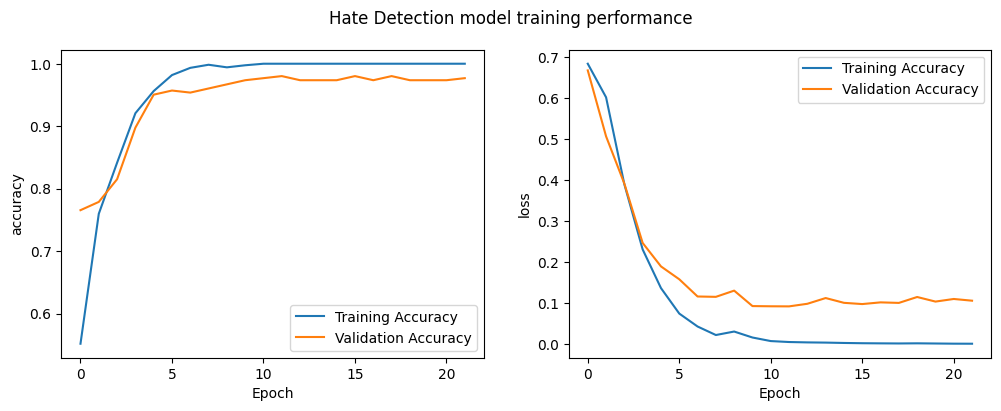

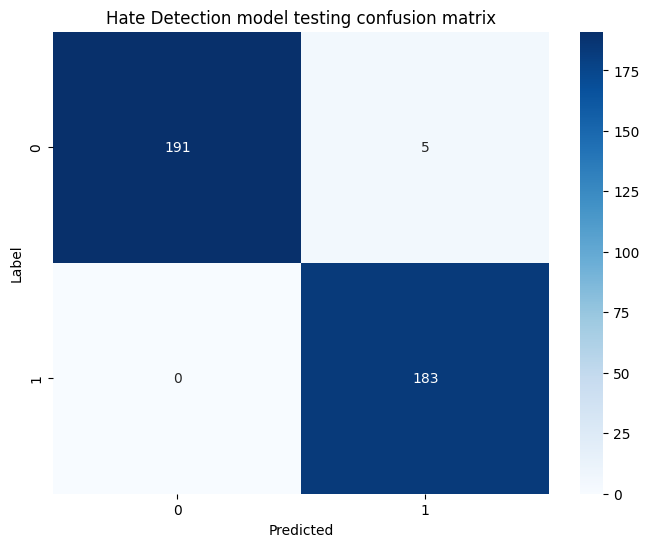

Hate Detection model testing:
Accuracy: 99.0%
Loss: 0.09
F1: 0.9868110632737993


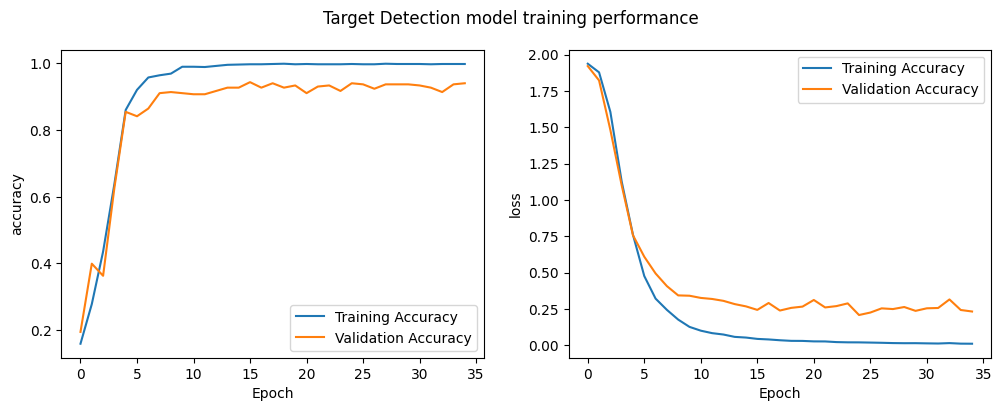

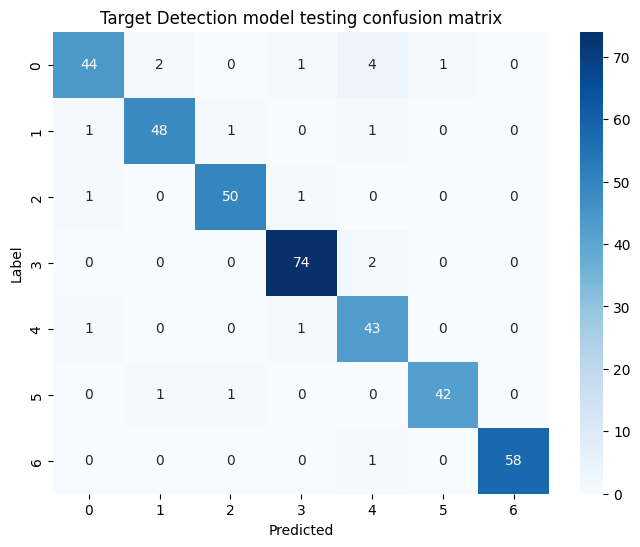

Target Detection model testing:
Accuracy: 95.0%
Loss: 0.21
F1: 0.9473075124219509


In [445]:
# Self explanatory code 
for (model_name, model), labels in zip(models.items(), [test_labels, test_targets]):
    test_loss, test_accuracy = model['model'].evaluate(test_texts, labels, verbose=0)
    predictions = model['model'].predict(test_texts, verbose=0)
    
    if labels.shape[1] == 1: # For binary model
        # Translate based on if prediction probability is above/below 50%
        predicted_classes = (predictions >= 0.5).astype(int).flatten()
        actual_classes = labels.flatten()
    else: # For multi-class model
        # Translate using argmax to convert into number labels
        predicted_classes = np.argmax(predictions, axis=1)
        actual_classes = np.argmax(labels, axis=1)

    f1 = f1_score(actual_classes, predicted_classes, average='weighted')
    cm = confusion_matrix(actual_classes, predicted_classes)
    
    plt.figure(figsize=(12, 4))
    
    for subplot, metric in enumerate(['accuracy', 'loss'], 1):
        plt.subplot(1, 2, subplot)
        plt.plot(model['history'].history[metric], label='Training Accuracy')
        plt.plot(model['history'].history[f'val_{metric}'], label='Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel(metric)
        plt.legend()

    plt.suptitle(f'{model_name} model training performance')
    plt.show()

    # Confusion matrix using seaborn as that was the simplest and best looking
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm,
        annot=True,
        fmt='d',
        cmap='Blues', 
        xticklabels=np.unique(actual_classes),
        yticklabels=np.unique(actual_classes)
    )
    
    plt.xlabel('Predicted')
    plt.ylabel('Label')
    plt.title(f'{model_name} model testing confusion matrix')
    plt.show()
    
    print(
        f'{model_name} model testing:\n'
        f'Accuracy: {round(test_accuracy, 2) * 100}%\n'
        f'Loss: {round(test_loss, 2)}\n'
        f'F1: {f1}'
    )

Real world usage

In [446]:
data[:10]

,text,label,target
0,The world would be worse off without Muslims l...,non-hateful,Muslims
1,I don't like people in general but I have no p...,non-hateful,gay people
2,You must be seriously sad to write things like...,non-hateful,gay people
3,I absolutely loathe black people.,hateful,black people
4,You disabled people are all dishonest.,hateful,disabled people
5,I will cut their female throats.,hateful,women
6,They must not get away with saying stuff like ...,non-hateful,women
7,There is nothing in the world I like less than...,hateful,gay people
8,Seeing immigrants in government makes me so pr...,non-hateful,immigrants
9,Women being in charge is a credit to our socie...,non-hateful,women


In [447]:
# Convert to series as that's what texts_to_sequences() expects 
text = pd.Series('I love women')

test = tokenizer.texts_to_sequences(pd.Series(text))
test

test = pad_sequences(test, maxlen=max_sequence_length)
test

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   6, 140,
         23]])

In [448]:
test = models['Hate Detection']['model'].predict(test, verbose=0)
test

array([[0.8834865]], dtype=float32)

In [449]:
test = (test >= 0.5).astype(int).flatten()
test

array([1])

### Q&A/Motivations

- #### Motivera din modell, dess arkitektur och val av relevanta hyperparametrar.
    After doing some data exploration/generally examining the dataset i noticed that the spesific problem i was trying to solve was essentially perfect for an LSTM. The snippets of texts where short and to the point with minimal context needed in order to determin hate/non-hatefulness as well as the target group.

    All i needed to do was train two models, one for each classification problem.

# TEMPLATE

- #### Motivera din modellarkitektur och val av relevanta hyperparametrar.<br>
    
    I initially settled on a "vanilla" RNN, but later decided on using an LSTM instead, given the task at hand. I non the less included both models for comparison purposes.
    
    The two models are both (obviously) based on the recurrent neural network architecture, with the only difference being that one is an LSTM. All other hyperparameters identical.

    We start off by running the data through an embedding layer, which converts the words/tokens into dense vectors of fixed size. This helps to capture semantic relationships as words with similar meanings tend to have similar vector representations. This is essentially a must for RNNs performing tasks such as semantic analysis. After embedding the data, we feed it into our RNN with 32 units and an activation function of tanh (more on why later) and finally out to our output dense layer. That's it!<br>
    It's an extremely simple yet surprisingly effective architecture.  

    Now for the hyperparameter choices, which I'll be elaborating and explaning one by one.
      
  - SimpleRNN/LSTM units
    - Experimented around with 8, 16, 32.. etc. until settling on 32, which gave me the best results. Essentially a bunch of trial and error.
      
  - SimpleRNN/LSTM activation
    - Used tanh as it was generally the most fitting for RNNs. tanh provides a number of benefits when it comes to RNNs given it's bounded to -1 - 1, making the network less likely to suffer from things like vanishing gradient problems.
  
  - Dense units/activation
    - 6 output neurons to account for our 6 labels, with the activation function being softmax as that helps in generating probabilities as output for classification.



- #### Vilka aktiveringsfunktioner har du använt? Varför?
  - Already stated above

- #### Vilken loss funktion har du använt? Varför?
  - Being that we're training a classifier, categorical_crossentropy seemed most appropriate. This because it's effective for training models to make accurate multi class predictions.

- #### Har du använt någon databehandling? Varför?
  - yes, plenty. In order for to feed textual data into the RNNs, i firstly needed to tokenize it. Tokenizing text simply converts it into a "sequence" of numbers which correspond to different words (delimited by a space). This is a must as neural networks work based off of numbers and not letters. The second order of business was to pad the sequences of numbers. Padding (in this case) involves ensuring that the sequences are of equal length, regardless of the underlying sentence length (which can obviously vary quite a bit). This is done by declaring a "window" of tokenized words which is than filled by zeros in order to "pad" the length up to a fixed size, in this case 100 words.
  Lastly, i than one-hot encoded the labels in order for them to work with the networks categorical_crossentropy loss function.<br><br>Now, i could've also remove the stop words and performed lemmatization, but i simply didn't see a need. The amount of data we have is minuscule. It simply wouldn't benefit it. I also doubt model performance would change much. If anything, it may go down as the data would contain slightly less contextual information.
  

- #### Har du använt någon regulariseringsteknik? Motivera.
  - Only early stopping. I was initially quite sure that I'd need to spend a good amount of time tinkering with various regularization techniques, but apparently not. The networks performed surprisingly well, with the only downside being that they started grossly overfitting at semi random epoch intervals. After having solved that issue, i opted for simplicity rather than pushing the bounds of accuracy.

- #### Hur har modellen utvärderats?
  - By looking at the test datas accuracy, loss f1 score and confusion matrix.

- #### Är prestandan bra? Varför/ varför inte?
  - Surprisingly.<br>
  Wasn't expecting the RNN to whip out an >80% accuracy given such a simple architecture. Likewise for the LSTM. Just goes to show how good RNNs are at finding meaning in sequences of data. The LSTM does a bit better than the vanilla RNN alone, to no ones surprise. This is due to the LSTM performing better on longer sentences given its ability to "recall" context from what it has "read" from in "the past". Much like us humans.

- #### Vad hade du kunnat göra för att förbättra den ytterligare?
  - I'll paraphrase the same thing i said in lab 1, as it very much still applies here.<br><br>There are a myriad of possible techniques which i didn't explore. Everything from simply continuing to mess around with the architecture, to performing a comprehensive gridsearch of the parameter space in order to obtain the best model. The addition of stop word removal, lemmatization or even just a few more dense layers may also have given the model a slight advantage. But that would've also made the train time far longer. All of this is to say that in this field of computer science, you can always tweak things. One must call it quits at some point! >80% accuracy is spectacular in my books, especially when considering the fact that you'd have gotten roughly 16% had the model simply guessed at random.